In [1]:
import json
import os
import re
import csv
import itertools
import matplotlib.pyplot as plt
import matplotlib.ticker

from dataclasses import dataclass
from pathlib import Path
from pprint import pprint

# Embed fonts into the PDF as TrueType instead of Type 3
plt.rcParams["pdf.fonttype"] = "truetype"

In [2]:
def save_figure(fig, path):
    fig.savefig(path, bbox_inches="tight")

def tabulate_results(ao, sphinx, columns):
    values = [list({getattr(x, column) for x in ao}) for column in columns]
    for col in values:
        col.sort()
    header = " | ".join(
        ["{:>13}".format(col) for col in columns] +
        ["{:>18}".format(name) for name in ["time (aimless)", "time (sphinx)"]]
    )
    print(header)
    for row in itertools.product(*values):
        finder = {k: v for k, v in zip(columns, row)}
        ao_data = find(ao, **finder)
        ao_field = "-" if ao_data is None else round(ao_data.mean_millis(), 2)
        finder = {k: v for k, v in finder.items() if k in {"path_length"}}
        sphinx_data = find(sphinx, **finder)
        sphinx_field = "-" if sphinx_data is None else round(sphinx_data.mean_millis(), 2)
        fields = " | ".join(
            ["{:>13}".format(val) for val in row] +
            ["{:>18}".format(field) for field in [ao_field, sphinx_field]]
        )
        print(fields)

## Hieararchy depth vs accuracy

In [3]:
import accuracy

def sort_by_depth(l):
    # They should come sorted, but ensure they actually are
    l.sort(key=lambda r: r.depth)

DEPTH = 32

tor_relays = accuracy.load_from_consensus(Path("aimless-onions/tor-consensus"))
accuracies_tor = list(accuracy.evaluate(tor_relays, depth_to=DEPTH))
sort_by_depth(accuracies_tor)

nym_relays = accuracy.load_from_nym_mixnodes(Path("nym-mixnodes"))
accuracies_nym = list(accuracy.evaluate(nym_relays, depth_to=DEPTH))
sort_by_depth(accuracies_nym)

loc = accuracy.GeoIpLocator()
loc.load("geoip2-ipv4.csv")

buckets_tor = accuracy.bucketize(loc, tor_relays)
accuracies_tor_buckets = list(accuracy.evaluate_buckets(buckets_tor, depth_to=DEPTH))
sort_by_depth(accuracies_tor_buckets)

buckets_nym = accuracy.bucketize(loc, nym_relays)
accuracies_nym_buckets = list(accuracy.evaluate_buckets(buckets_nym, depth_to=DEPTH))
sort_by_depth(accuracies_nym_buckets)

buckets_tor_coarse = accuracy.bucketize_coarse(loc, tor_relays)
accuracies_tor_coarse = list(accuracy.evaluate_buckets(buckets_tor_coarse, depth_to=DEPTH))
sort_by_depth(accuracies_tor_coarse)

buckets_nym_coarse = accuracy.bucketize_coarse(loc, nym_relays)
accuracies_nym_coarse = list(accuracy.evaluate_buckets(buckets_nym_coarse, depth_to=DEPTH))
sort_by_depth(accuracies_nym_coarse)

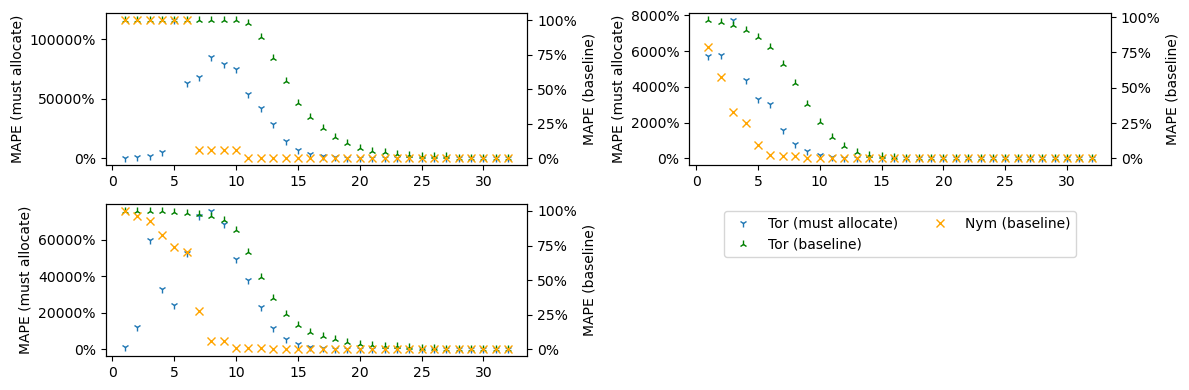

In [4]:
def plot_accuracies(ax, accs_tor, accs_nym):
    ln1 = ax.plot(
        [r.depth for r in accs_tor],
        [r.mape_with for r in accs_tor],
        "1",
        label="Tor (must allocate)",
    )
    ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter())
    ax.set_ylabel("MAPE (must allocate)")

    ax2 = ax.twinx()
    ln2 = ax2.plot(
        [r.depth for r in accs_tor],
        [r.mape_without for r in accs_tor],
        "2",
        label="Tor (baseline)",
        color="green",
        #linestyle="dashed",
    )
    ax2.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter())
    ax2.set_ylabel("MAPE (baseline)")

    if accs_nym:
        ln3 = ax2.plot(
            [r.depth for r in accs_nym],
            [r.mape_without for r in accs_nym],
            "x",
            label="Nym (baseline)",
            color="orange",
            #linestyle="dashed",
        )
    else:
        ln3 = []

    # Shared legend
    lns = ln1 + ln2 + ln3
    labels = [l.get_label() for l in lns]
    #ax.legend(lns, labels)

def plot_legend(ax):
    ln = []
    ln.extend(ax.plot([], [], "1", label="Tor (must allocate)"))
    ln.extend(ax.plot([], [], "2", label="Tor (baseline)", color="green"))
    ln.extend(ax.plot([], [], "x", label="Nym (baseline)", color="orange"))
    ax.set_axis_off()
    ax.legend(ln, [l.get_label() for l in ln], loc="upper center", ncols=2)

fig, axs = plt.subplots(2, 2, layout="tight", figsize=(12, 4))
plot_accuracies(axs[0][0], accuracies_tor, accuracies_nym)
plot_accuracies(axs[0][1], accuracies_tor_buckets, accuracies_nym_buckets)
plot_accuracies(axs[1][0], accuracies_tor_coarse, accuracies_nym_coarse)
plot_legend(axs[1][1])
save_figure(fig, Path("results/depth-vs-accuracy.pdf"))

This image is Figure 3 in the paper.

## Implementation benchmarks

In [5]:
@dataclass
class AimlessResult:
    basename: str
    path_length: int
    authorities: int
    payload_size: int
    mean: float
    mean_lower: float
    mean_upper: float
    standard_error: float

    def mean_millis(self):
        return self.mean / 1_000_000

    def mean_lower_millis(self):
        return self.mean_lower / 1_000_000

    def mean_upper_millis(self):
        return self.mean_upper / 1_000_000

    def error_lower_millis(self):
        return self.mean_millis() - self.mean_lower_millis()

    def error_upper_millis(self):
        return self.mean_upper_millis() - self.mean_millis()
        
    def standard_error_millis(self):
        return self.standard_error / 1_000_000


def params_from_function_id(n):
    params = {
        "path_length": 0,
        "authorities": 0,
        "payload_size": 0,
    }
    parts = n.split("/")
    params["basename"] = parts[0]
    if len(parts) == 4:
        params["path_length"] = int(parts[1])
        params["authorities"] = int(parts[2])
        params["payload_size"] = int(parts[3])
    elif len(parts) == 3:
        params["authorities"] = int(parts[1])
        params["payload_size"] = int(parts[2])
    return params


def read_ao_results(path: Path) -> list[AimlessResult]:
    result = []
    for name, dirs, files in os.walk(path):
        if "new" in dirs and "base" in dirs:
            metadata = json.loads((Path(name) / "new" / "benchmark.json").read_text())
            if not re.match("(wrap|unwrap|keygen)", metadata["function_id"]):
                continue
            estimates = json.loads((Path(name) / "new" / "estimates.json").read_text())
            benchmark = AimlessResult(
                mean=estimates["mean"]["point_estimate"],
                mean_lower=estimates["mean"]["confidence_interval"]["lower_bound"],
                mean_upper=estimates["mean"]["confidence_interval"]["upper_bound"],
                standard_error=estimates["mean"]["standard_error"],
                **params_from_function_id(metadata["function_id"])
            )
            result.append(benchmark)
    return result

In [6]:
@dataclass
class SphinxResult:
    path_length: int
    mean: float
    mean_lower: float
    mean_upper: float
    standard_error: float

    def mean_millis(self):
        return self.mean / 1_000_000
    
    def mean_lower_millis(self):
        return self.mean_lower / 1_000_000

    def mean_upper_millis(self):
        return self.mean_upper / 1_000_000

    def error_lower_millis(self):
        return self.mean_millis() - self.mean_lower_millis()

    def error_upper_millis(self):
        return self.mean_upper_millis() - self.mean_millis()

    def standard_error_millis(self):
        return self.standard_error / 1_000_000

def read_sphinx_results(path: Path, name: str) -> list[SphinxResult]:
    result = []
    for subdir in path.iterdir():
        match = re.match("length_(\\d+)$", subdir.name)
        if not match:
            continue
        base = subdir / name / "new"
        estimates = json.loads((base / "estimates.json").read_text())
        benchmark = SphinxResult(
            path_length=int(match.group(1)),
            mean=estimates["mean"]["point_estimate"],
            mean_lower=estimates["mean"]["confidence_interval"]["lower_bound"],
            mean_upper=estimates["mean"]["confidence_interval"]["upper_bound"],
            standard_error=estimates["mean"]["standard_error"],
        )
        result.append(benchmark)
    return result

In [7]:
def find(l, **kwargs):
    for item in l:
        if all(getattr(item, k) == v for k, v in kwargs.items()):
            return item
    return None

def yerr(results):
    return [[b.error_lower_millis() for b in results], [b.error_upper_millis() for b in results]]

### Client benchmark (onion creation)

In [8]:
ao_wrap = read_ao_results(Path("aimless-onions/target/criterion/client"))
sphinx_wrap = read_sphinx_results(Path("sphinx-benchmarks/target/criterion/"), "sphinx creation")

In [9]:
def plot_wrap_time_vs_authorities(ax):
    results = [
        b for b in ao_wrap
        if b.path_length == 3 and b.payload_size == 1024
    ]
    results.sort(key=lambda b: b.authorities)
    ax.errorbar([b.authorities for b in results], [b.mean_millis() for b in results], yerr=yerr(results), label="Aimless", fmt="o")

    result = find(sphinx_wrap, path_length=3)
    ax.errorbar([b.authorities for b in results], [result.mean_millis() for b in results], yerr=yerr(results), label="Sphinx", fmt="o")

    ax.set_ylim((0, 1000))
    ax.set_ylabel("Time [ms]")
    ax.set_xlabel("Authority count")
    ax.set_xticks(list(range(1, 10)))
    ax.legend()

def tabulate_wrap_time_vs_authorities():
    results = [
        b for b in ao_wrap
        if b.path_length == 3 and b.payload_size == 1024
    ]
    results.sort(key=lambda b: b.authorities)

    result = find(sphinx_wrap, path_length=3)

    print("\\toprule")
    print("\\textbf{Format} & \\textbf{Authorities} & \\textbf{Avg. Time [ms]} \\\\")
    print("\\midrule")
    print("{:<15} & {:<20} & {:<23.2f} ($\\pm {:.2f}$) \\\\".format("Sphinx", "", result.mean_millis(), result.standard_error_millis()))
    for r in results:
        print("{:<15} & {:<20} & {:<23.2f} ($\\pm {:.2f}$) \\\\".format("", r.authorities, r.mean_millis(), r.standard_error_millis()))
    print("\\bottomrule")

In [10]:
def plot_wrap_time_vs_path_length(ax):    
    results = [
        b for b in ao_wrap
        if b.authorities == 3 and b.payload_size == 1024
    ]
    results.sort(key=lambda b: b.path_length)
    ax.errorbar([b.path_length for b in results], [b.mean_millis() for b in results], yerr=yerr(results), label="Aimless", fmt="o")

    ax2 = ax.twinx()
    results = sphinx_wrap[:]
    results.sort(key=lambda b: b.path_length)
    ax2.errorbar([b.path_length for b in results], [b.mean_millis() for b in results], yerr=yerr(results), label="Sphinx", fmt="oC1")

    ax.set_ylabel("Aimless time [ms]")
    ax.set_xlabel("Path length")
    ax.set_xticks(list(range(1, 6)))
    ax2.set_ylabel("Sphinx time [ms]")
    ax.legend()
    ax2.legend(loc="right")

In [11]:
def plot_wrap_time_vs_payload_size(ax):    
    results = [
        b for b in ao_wrap
        if b.authorities == 3 and b.path_length == 3
    ]
    results.sort(key=lambda b: b.payload_size)
    ax.plot([b.payload_size for b in results], [b.mean_millis() for b in results], label="Aimless")

    result = find(sphinx_wrap, path_length=3)
    ax.plot([b.payload_size for b in results], [result.mean_millis() for b in results], label="Sphinx")

    ax.set_yscale("log")
    ax.set_ylim((0.01, 500))
    ax.set_ylabel("Time [ms]")
    ax.set_xlabel("Payload size [bytes]")
    ax.legend()

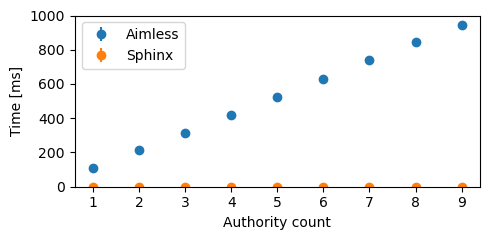

In [12]:
fig, axs = plt.subplots(1, 1, layout="tight", figsize=(5, 2.5))
plot_wrap_time_vs_authorities(axs)
save_figure(fig, Path("results/time-client-authorities.pdf"))

In [13]:
tabulate_wrap_time_vs_authorities()

\toprule
\textbf{Format} & \textbf{Authorities} & \textbf{Avg. Time [ms]} \\
\midrule
Sphinx          &                      & 0.19                    ($\pm 0.00$) \\
                & 1                    & 110.04                  ($\pm 0.21$) \\
                & 2                    & 211.88                  ($\pm 0.26$) \\
                & 3                    & 316.48                  ($\pm 0.08$) \\
                & 4                    & 420.85                  ($\pm 0.13$) \\
                & 5                    & 526.58                  ($\pm 0.19$) \\
                & 6                    & 629.93                  ($\pm 0.09$) \\
                & 7                    & 737.39                  ($\pm 0.60$) \\
                & 8                    & 842.36                  ($\pm 0.48$) \\
                & 9                    & 946.20                  ($\pm 0.18$) \\
\bottomrule


The above figure is not part of the paper, but the table is included as Table 2 (truncated in the paper).

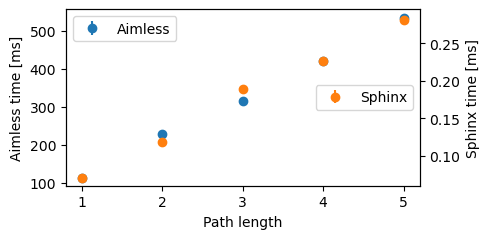

In [14]:
fig, axs = plt.subplots(1, 1, layout="tight", figsize=(5, 2.5))
plot_wrap_time_vs_path_length(axs)
save_figure(fig, Path("results/time-client-path.pdf"))

In [15]:
tabulate_results(ao_wrap, sphinx_wrap, ["authorities", "path_length", "payload_size"])

  authorities |   path_length |  payload_size |     time (aimless) |      time (sphinx)
            1 |             1 |           512 |              38.09 |               0.07
            1 |             1 |          1024 |              37.77 |               0.07
            1 |             1 |          2048 |              37.92 |               0.07
            1 |             1 |          4069 |              37.89 |               0.07
            1 |             2 |           512 |              73.47 |               0.12
            1 |             2 |          1024 |              75.83 |               0.12
            1 |             2 |          2048 |              73.92 |               0.12
            1 |             2 |          4069 |              74.94 |               0.12
            1 |             3 |           512 |             109.94 |               0.19
            1 |             3 |          1024 |             110.04 |               0.19
            1 |             3 | 

The above figure is Figure 5 in the paper. The table is not included verbatim, but is used to get exact values for the body text.

### Relay benchmark (onion unwrapping)

In [16]:
ao_unwrap = read_ao_results(Path("aimless-onions/target/criterion/relay"))
sphinx_unwrap = read_sphinx_results(Path("sphinx-benchmarks/target/criterion/"), "sphinx unwrap")

In [17]:
def plot_unwrap_time_vs_authorities(ax):
    results = [
        b for b in ao_unwrap
        if b.payload_size == 1024
    ]
    results.sort(key=lambda b: b.authorities)
    ax.errorbar([b.authorities for b in results], [b.mean_millis() for b in results], yerr=yerr(results), label="Aimless", fmt="o")

    result = find(sphinx_unwrap, path_length=3)
    ax.errorbar([b.authorities for b in results], [result.mean_millis() for b in results], yerr=yerr(results), label="Sphinx", fmt="o")

    #ax.set_ylim((0, 1000))
    ax.set_ylabel("Time [ms]")
    ax.set_xlabel("Authority count")
    ax.legend()

def tabulate_unwrap_time_vs_authorities():
    results = [
        b for b in ao_unwrap
        if b.payload_size == 1024
    ]
    results.sort(key=lambda b: b.authorities)

    result = find(sphinx_unwrap, path_length=3)

    print("\\toprule")
    print("\\textbf{Format} & \\textbf{Authorities} & \\textbf{Avg. Time [ms]} \\\\")
    print("\\midrule")
    print("{:<15} & {:<20} & {:<23.2f} ($\\pm {:.2f}$) \\\\".format("Sphinx", "", result.mean_millis(), result.standard_error_millis()))
    for r in results:
        print("{:<15} & {:<20} & {:<23.2f} ($\\pm {:.2f}$) \\\\".format("", r.authorities, r.mean_millis(), r.standard_error_millis()))
    print("\\bottomrule")

In [18]:
def plot_unwrap_time_vs_payload_size(ax):    
    results = [
        b for b in ao_unwrap
        if b.authorities == 3
    ]
    results.sort(key=lambda b: b.payload_size)
    ax.plot([b.payload_size for b in results], [b.mean_millis() for b in results], label="Aimless")

    result = find(sphinx_unwrap, path_length=3)
    ax.plot([b.payload_size for b in results], [result.mean_millis() for b in results], label="Sphinx")

    #ax.set_yscale("log")
    #ax.set_ylim((0.01, 500))
    ax.set_ylabel("Time [ms]")
    ax.set_xlabel("Payload size [bytes]")
    ax.legend()

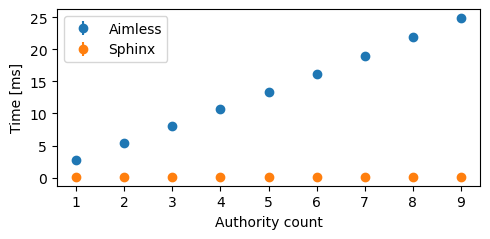

In [19]:
fig, axs = plt.subplots(1, 1, layout="tight", figsize=(5, 2.5))
plot_unwrap_time_vs_authorities(axs)
save_figure(fig, Path("results/time-relay-authority.pdf"))

In [20]:
tabulate_unwrap_time_vs_authorities()

\toprule
\textbf{Format} & \textbf{Authorities} & \textbf{Avg. Time [ms]} \\
\midrule
Sphinx          &                      & 0.10                    ($\pm 0.00$) \\
                & 1                    & 2.69                    ($\pm 0.00$) \\
                & 2                    & 5.37                    ($\pm 0.00$) \\
                & 3                    & 8.06                    ($\pm 0.01$) \\
                & 4                    & 10.70                   ($\pm 0.00$) \\
                & 5                    & 13.39                   ($\pm 0.01$) \\
                & 6                    & 16.06                   ($\pm 0.01$) \\
                & 7                    & 18.87                   ($\pm 0.02$) \\
                & 8                    & 21.85                   ($\pm 0.03$) \\
                & 9                    & 24.88                   ($\pm 0.06$) \\
\bottomrule


The above figure is not included in the paper, but the table is Table 3 (truncated in the paper).

In [21]:
tabulate_results(ao_unwrap, sphinx_unwrap, ["authorities", "payload_size"])

  authorities |  payload_size |     time (aimless) |      time (sphinx)
            1 |           512 |                2.7 |               0.05
            1 |          1024 |               2.69 |               0.05
            1 |          2048 |               2.69 |               0.05
            1 |          4069 |               2.69 |               0.05
            2 |           512 |               5.36 |               0.05
            2 |          1024 |               5.37 |               0.05
            2 |          2048 |               5.36 |               0.05
            2 |          4069 |               5.36 |               0.05
            3 |           512 |               8.03 |               0.05
            3 |          1024 |               8.06 |               0.05
            3 |          2048 |               8.06 |               0.05
            3 |          4069 |               8.04 |               0.05
            4 |           512 |               10.7 |            

### Relay benchmark (key derivation)

In [22]:
def read_keyderive_results(path: Path) -> list[AimlessResult]:
    result = []
    for name, dirs, files in os.walk(path):
        if "new" in dirs and "base" in dirs:
            metadata = json.loads((Path(name) / "new" / "benchmark.json").read_text())
            if not re.match("(derive|derive_cached)", metadata["function_id"]):
                continue
            estimates = json.loads((Path(name) / "new" / "estimates.json").read_text())
            basename, authorities = metadata["function_id"].split("/")
            benchmark = AimlessResult(
                mean=estimates["mean"]["point_estimate"],
                mean_lower=estimates["mean"]["confidence_interval"]["lower_bound"],
                mean_upper=estimates["mean"]["confidence_interval"]["upper_bound"],
                standard_error=estimates["mean"]["standard_error"],
                basename=basename,
                authorities=int(authorities),
                payload_size=0,
                path_length=0,
            )
            result.append(benchmark)
    return result

ao_keyderive = read_keyderive_results(Path("aimless-onions/target/criterion/relay/"))

In [23]:
def plot_keyderive_time_vs_authorities(ax):
    results = [
        b for b in ao_keyderive
        if "cached" in b.basename
    ]
    results.sort(key=lambda b: b.authorities)
    ax.errorbar([b.authorities for b in results], [b.mean_millis() for b in results], yerr=yerr(results), label="Aimless", fmt="o")

    #ax.set_ylim((0, 1000))
    ax.set_ylabel("Time [ms]")
    ax.set_xlabel("Authority count")
    ax.legend()

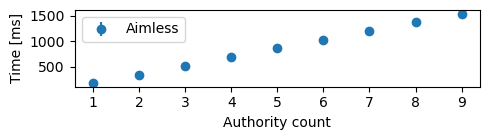

In [24]:
fig, axs = plt.subplots(1, 1, layout="tight", figsize=(5, 1.5))
plot_keyderive_time_vs_authorities(axs)
save_figure(fig, Path("results/time-relay-keyderive-authority.pdf"))

This figure is not included in the paper.

In [25]:
per_authority_derivation = next(r for r in ao_keyderive if "cached" in r.basename and r.authorities == 9)
pprint(per_authority_derivation)
print(per_authority_derivation.mean_millis())

AimlessResult(basename='derive_cached',
              path_length=0,
              authorities=9,
              payload_size=0,
              mean=1541706269.29,
              mean_lower=1539544873.11325,
              mean_upper=1543925895.9537501,
              standard_error=1114477.999440293)
1541.70626929


### Authority benchmark (key generation)

In [26]:
ao_keygen = read_ao_results(Path("aimless-onions/target/criterion/authority"))

In [27]:
def tabulate_keygen_infos():
    kg = ao_keygen[0]
    print(f"Key generation: {kg.mean_millis():.2f}ms")
    kps = 1_000 / kg.mean_millis()
    print(f"Keys/second:    {kps:.2f}")

tabulate_keygen_infos()

Key generation: 201.07ms
Keys/second:    4.97


## Onion size

In [28]:
@dataclass
class Size:
    path_length: int
    authorities: int
    payload_size: int
    onion_size: int

def read_ao_sizes(path: Path) -> list[Size]:
    result = []
    with open(path, newline="") as fobj:
        reader = csv.reader(fobj)
        # Skip header
        next(reader)
        for row in reader:
            size = Size(
                path_length=int(row[0]),
                authorities=int(row[1]),
                payload_size=int(row[2]),
                onion_size=int(row[3]),
            )
            result.append(size)
    return result

def read_sphinx_sizes(path: Path) -> list[Size]:
    result = []
    with open(path, newline="") as fobj:
        reader = csv.reader(fobj)
        next(reader)
        for row in reader:
            size = Size(
                path_length=int(row[0]),
                authorities=0,
                payload_size=int(row[1]),
                onion_size=int(row[2]),
            )
            result.append(size)
    return result

In [29]:
ao_sizes = read_ao_sizes(Path("aimless-onions/onion_sizes.csv"))
sphinx_sizes = read_sphinx_sizes(Path("sphinx-benchmarks/sphinx_onion_sizes.csv"))

In [30]:
def plot_onion_size_vs_authorities(ax):
    results = [
        r for r in ao_sizes
        if r.path_length == 5 and r.payload_size == 1024
    ]
    ax.scatter([r.authorities for r in results], [r.onion_size for r in results], label="Aimless")

    result = find(sphinx_sizes, payload_size=1024, path_length=5)
    ax.scatter([r.authorities for r in results], [result.onion_size for _ in results], label="Sphinx")

    ax.set_ylabel("Onion size [bytes]")
    ax.set_xlabel("Authorities")

In [31]:
def plot_onion_size_vs_path_length(ax):
    results = [
        r for r in ao_sizes
        if r.authorities == 3 and r.payload_size == 1024
    ]
    ax.scatter([r.path_length for r in results], [r.onion_size for r in results], label="Aimless")

    results = [
        r for r in sphinx_sizes
        if r.payload_size == 1024
    ]
    ax.scatter([r.path_length for r in results], [r.onion_size for r in results], label="Sphinx")

    ax.set_ylabel("Onion size [bytes]")
    ax.set_xlabel("Path Length")

In [32]:
def plot_onion_size_vs_payload_size(ax):
    results = [
        r for r in ao_sizes
        if r.authorities == 3 and r.path_length == 3
    ]
    ax.plot([r.payload_size for r in results], [r.onion_size for r in results], label="Aimless")

    results = [
        r for r in sphinx_sizes
        if r.path_length == 3
    ]
    ax.plot([r.payload_size for r in results], [r.onion_size for r in results], label="Sphinx")

    ax.set_ylabel("Onion size [bytes]")
    ax.set_xlabel("Payload size [bytes]")

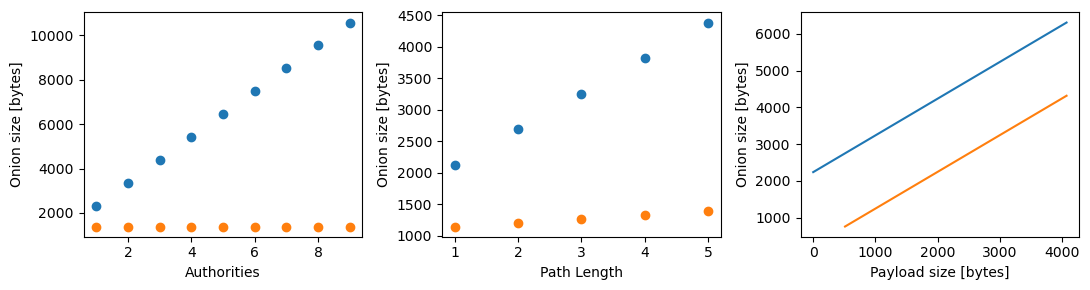

In [33]:
fig, axs = plt.subplots(1, 3, layout="tight", figsize=(11, 3))
plot_onion_size_vs_authorities(axs[0])
plot_onion_size_vs_path_length(axs[1])
plot_onion_size_vs_payload_size(axs[2])
save_figure(fig, "results/size.pdf")

This figure is not included in the paper.

## Break-even points

In [34]:
def breakeven(authorities, path_length, consensus_size):
    # The payload size cancels each other out, as the break-even point only depends
    # on the additional overhead that Aimless Onions have over Sphinx. Therefore,
    # just pick a payload, it will cancel each other out anyway.
    payload_size = next(iter({r.payload_size for r in ao_sizes} & {r.payload_size for r in sphinx_sizes}))
    ao_size = find(ao_sizes, authorities=authorities, payload_size=payload_size, path_length=path_length)
    assert ao_size
    sphinx_size = find(sphinx_sizes, authorities=0, payload_size=payload_size, path_length=path_length)
    assert sphinx_size

    ao_overhead = ao_size.onion_size - sphinx_size.onion_size
    return consensus_size / ao_overhead

# See the paper on how we determined those values
TOR_CONSENSUS_SIZE = 632 * 1024
TOR_DIFF_SIZE = 415 * 1024
NYM_CONSENSUS_SIZE = 246 * 1024

print("Breakeven with Tor:", breakeven(9, 3, TOR_CONSENSUS_SIZE))
print("Breakeven with Tor (diff updates):", breakeven(9, 3, TOR_DIFF_SIZE))
print("Breakeven with Nym:", breakeven(9, 5, NYM_CONSENSUS_SIZE))

Breakeven with Tor: 105.76368687694068
Breakeven with Tor (diff updates): 69.44925641444681
Breakeven with Nym: 27.407681427483407


In [35]:
def plot_bandwidth_vs_onion_count(ax, consensus_sizes, path_length, start=1, stop=1000):
    payload_size = next(iter({r.payload_size for r in ao_sizes} & {r.payload_size for r in sphinx_sizes}))

    ao_lines = []
    sphinx_lines = []
    for authorities in [1, 5, 9]:   
        ao_single = find(ao_sizes, authorities=authorities, payload_size=payload_size, path_length=path_length).onion_size
        sphinx_single = find(sphinx_sizes, authorities=0, payload_size=payload_size, path_length=path_length).onion_size
        
        ao = []
        counts = list(range(start, stop + 1))
        
        for count in counts:
            ao.append((count * ao_single) / 1024)

        ao_lines.append((f"Aimless ({authorities})", ao))
        
        if authorities == 1:
            for label, consensus_size in consensus_sizes:
                sphinx = []
                for count in counts:
                    sphinx.append((consensus_size + count * sphinx_single) / 1024)
                sphinx_lines.append((label, sphinx))

    for label, data in ao_lines:
        ax.plot(counts, data, label=label)
    for label, data in sphinx_lines:
        ax.plot(counts, data, label=label, linestyle="dashed")
    ax.set_ylabel("Total data [KiB]")
    ax.set_xlabel("Number of onions")
    ax.set_yticks(list(range(0, int(ao[-1]), 1024 // 4)))
    ax.legend(ncols=2)

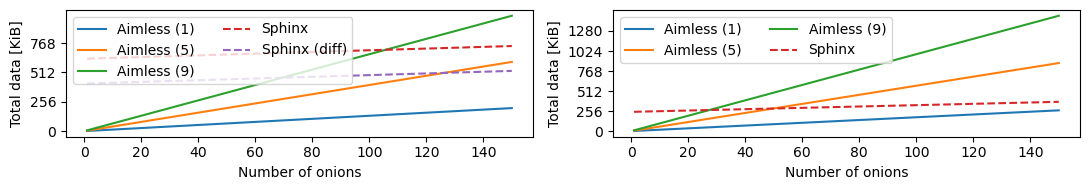

In [36]:
fig, axs = plt.subplots(1, 2, layout="tight", figsize=(11, 2))
plot_bandwidth_vs_onion_count(axs[0], [("Sphinx", TOR_CONSENSUS_SIZE), ("Sphinx (diff)", TOR_DIFF_SIZE)], 3, stop=150)
plot_bandwidth_vs_onion_count(axs[1], [("Sphinx", NYM_CONSENSUS_SIZE)], 5, stop=150)
save_figure(fig, "results/total-data.pdf")

This figure is Figure 6 in the paper.

In [37]:
def percentage_saving(num_onions, authorities, path_length, consensus_size):
    payload_size = next(iter({r.payload_size for r in ao_sizes} & {r.payload_size for r in sphinx_sizes}))
    ao_size = find(ao_sizes, authorities=authorities, payload_size=payload_size, path_length=path_length)
    assert ao_size
    sphinx_size = find(sphinx_sizes, authorities=0, payload_size=payload_size, path_length=path_length)
    assert sphinx_size

    ao_saving = 1 - (ao_size.onion_size * num_onions / (sphinx_size.onion_size * num_onions + consensus_size))
    return ao_saving

In [38]:
print(percentage_saving(25, 9, 3, TOR_CONSENSUS_SIZE))

0.7419279289828897


## Hierarchy Depth vs. Execution

In [39]:
def load_depth_results(path: Path) -> dict[int, AimlessResult]:
    results = {}
    for subfolder in path.iterdir():
        depth = int(subfolder.name.split("-")[1])
        results[depth] = []
        results[depth].extend(read_ao_results(subfolder / "client"))
        results[depth].extend(read_ao_results(subfolder / "relay"))
        results[depth].extend(read_ao_results(subfolder / "authority"))
        results[depth].extend(read_keyderive_results(subfolder / "relay"))
    return results

def plot_depth_vs_wrap(ax, data, authorities, path_length):
    x_ax = []
    y_ax = []
    for depth, results in sorted(data.items()):
        result = [
            r for r in results
            if r.basename == "wrap" and r.authorities == authorities and r.path_length == path_length and r.payload_size == 1024
        ]
        assert len(result) == 1
        result = result[0]
        x_ax.append(depth)
        y_ax.append(result.mean_millis())
    ax.plot(x_ax, y_ax, "1")
    ax.set_title("Onion wrap")
    ax.set_ylabel("Time [ms]")
    ax.set_xlabel("Hierarchy depth")
    #ax.xaxis.set_ticks(x_ax)

def plot_depth_vs_unwrap(ax, data, authorities):
    x_ax = []
    y_ax = []
    for depth, results in sorted(data.items()):
        result = [
            r for r in results
            if r.basename == "unwrap" and r.authorities == authorities and r.payload_size == 1024
        ]
        assert len(result) == 1
        result = result[0]
        x_ax.append(depth)
        y_ax.append(result.mean_millis())
    ax.plot(x_ax, y_ax, "1")
    ax.set_title("Onion unwrap")
    ax.set_ylabel("Time [ms]")
    ax.set_xlabel("Hierarchy depth")
    #ax.xaxis.set_ticks(x_ax)

def plot_depth_vs_derive(ax, data, authorities):
    x_ax = []
    y_ax = []
    for depth, results in sorted(data.items()):
        result = [
            r for r in results
            if "cached" in r.basename and r.authorities == authorities
        ]
        assert len(result) == 1
        result = result[0]
        x_ax.append(depth)
        y_ax.append(result.mean_millis())
    ax.plot(x_ax, y_ax, "1")
    ax.set_title("Relay keyderive")
    ax.set_ylabel("Time [ms]")
    ax.set_xlabel("Hierarchy depth")
    #ax.xaxis.set_ticks(x_ax)

def plot_depth_vs_keygen(ax, data):
    x_ax = []
    y_ax = []
    for depth, results in sorted(data.items()):
        result = [
            r for r in results
            if "keygen" in r.basename
        ]
        assert len(result) == 1
        result = result[0]
        x_ax.append(depth)
        y_ax.append(result.mean_millis())
    ax.plot(x_ax, y_ax, "1")
    ax.set_title("Authority keygen")
    ax.set_ylabel("Time [ms]")
    ax.set_xlabel("Hierarchy depth")
    #ax.xaxis.set_ticks(x_ax)

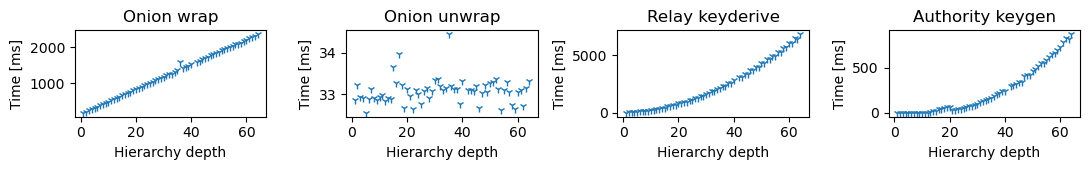

In [40]:
per_depth = load_depth_results(Path("aimless-onions/criterion-results"))
fig, axs = plt.subplots(1, 4, layout="tight", figsize=(11, 1.8))
plot_depth_vs_wrap(axs[0], per_depth, 9, 3)
plot_depth_vs_unwrap(axs[1], per_depth, 9)
plot_depth_vs_derive(axs[2], per_depth, 9)
plot_depth_vs_keygen(axs[3], per_depth)
save_figure(fig, "results/time-vs-depth.pdf")

This figure is Figure 4 in the paper.

If you run the fast benchmark suite, the plots will only have one data point (for hierarchy depth 32).

## Double-choosing probability

In [41]:
import doublechoose

prob_tor_relays = doublechoose.load_from_consensus("aimless-onions/tor-consensus")
double_tor = doublechoose.probability(prob_tor_relays, 3)
double_nym = doublechoose.probability([1] * 240, 5)

print("Probability to choose a node twice:")
print(f"  Tor-like ({len(prob_tor_relays)} nodes): {double_tor * 100:.2f}%")
print(f"  Nym-like ( 240 nodes): {double_nym * 100:.2f}%")

Probability to choose a node twice:
  Tor-like (8414 nodes): 0.08%
  Nym-like ( 240 nodes): 4.08%
